## Introduction 

In this project, I apply ARIMA method to forecast next day closing price of AAPL (Apple Inc.). The dataset is downloaded from Yahoo Finance. The model is evaluated based on two aspects: 
* Price Prediction Accuracy: The ability to accurately predict the next day's price. 
* Price Direction Accuracy: The ability to forecast the direction of the next day's price (increase or decrease). 

This model is applied for timeframe 1/1/2020-31/12/2021.

---

## 1. What is ARIMA model

ARIMA (Autoregressive Integrated Moving Average is one of the most popular and effective model in time series forecasting. It is designed to utilize the inherent autocorrelations present in the data to predict future values. The ideology behind ARIMA revolves around three fundamental components:: 

* Auto Regression: Measure the relationship between an obvervation and its lagged observations.
* Intergrated: The step involves differencing the time series data to achieve stationarity. 
* Moving Avergae: Measure the relationship between an observation with rediual errors from the past value predictions. 

Implementing ARIMA(p,d,q) model is determining parameters p,d,q which is time lags corresponding to three main components AR, I, and MA. 

#### AR - Auto Regressive

Auto regressive method utilizes a regression framework to predict a variable based on its past values. An AR model with order p can be written as: 
$$
y_t=c+\phi_1 y_{t-1}+\phi_2 y_{t-2}+\cdots+\phi_p y_{t-p}+\varepsilon_t
$$
$y_t$ represents the variable to be predicted at time t. p is the number of time lags used. The coefficients $\phi_1,...,\phi_{t-p}$ determine the influence of each lagged variable on the current value of $y_t$.  Value of $y_t$ is determined by a multiple linear regression of p independent variables $y_{t-1},y_{t-2},...,y_{t-p}$.

#### MA - Moving Average

The moving average (MA) method aims to capture the relationship between an observation and the residual errors of previous predictions. In an MA model of order q, it can be expressed as follows:
$$
y_t=c+\varepsilon_t+\theta_1 \varepsilon_{t-1}+\theta_2 \varepsilon_{t-2}+\cdots+\theta_q \varepsilon_{t-q}
$$
The term $\varepsilon_t$ represents the error or residual at time t, which is the difference between the actual value of $y_t$ and the forecasted value based on previous predictions. The value $y_t$ is computed based on the q errors $\varepsilon$ made by the previous model. So, each successive term looks one step further into the past to incorporate the mistakes made by that model in the current computation.

#### I - Itergrated

Itergrated is a technique to make time series data stationary, which is a crucial requirement for modeling a time series data. Stationarity is important in time series analysis because it ensures that the statistical properties of the data, such as mean and variance, remain constant over time. This assumption is necessary because if the model is changing over time, it becomes challenging to estimate the parameters accurately.

To achieve stationarity, one common approach is differencing, which involves computing the differences between consecutive observations in the time series. Differencing helps stabilize the mean of the time series by eliminating changes in its level, effectively removing trends and seasonality.

In the the ARIMA model, the parameter 'd' represents the number of times the differencing operation is applied to the time series. Each differencing operation subtracts the value of the current observation $y_t$ by the lagged value $y_{t-d}$.

--- 

## 2. Determine ARIMA(p,d,q) parameters

I apply ARIMA model to predict the next closing price of Apple stock. The stock price is downloaded from Yahoo Finance.

This sector includes: 
* Import dataset
* Check time series stationary and determine I(d)
* Determine AR(p), MA(q) parameters by ACF, PACF
* Determine AR(p), MA(q), I(d) parameters by Auto ARIMA library

### Import dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plta
from pandas.plotting import register_matplotlib_converters
# arima model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsap
# error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make combination 
import itertools 
#
import warnings
warnings.filterwarnings("ignore")

In [13]:
ticker = 'AAPL'
startdate, enddate = '2020-01-01', '2021-12-31'
df_all = pd.read_csv('./data/' + ticker + '.csv')
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.set_index('Date', inplace = True)

df = df_all.loc[startdate:enddate,['Adj Close']]
df = df.rename(columns = {'Adj Close':'close'})
df.head()

,close
Date,
2020-01-02,73.347939
2020-01-03,72.634842
2020-01-06,73.213623
2020-01-07,72.869286
2020-01-08,74.041489


In [8]:
N = len(df)
N

505

## 2.1. Check stationary and determine I(d)

### Check Stationary 

The augmented Dickey-Fuller (ADF) test is widely used to determine the stationarity of a time series. It is a statistical test where the null hypothesis assumes that the time series is non-stationary due to the presence of trends. The alternative hypothesis, on the other hand, suggests that the time series is stationary.

To apply the ADF test and assess the stationarity of a time series with a 95% confidence level, you can check if the p-value returned by the adfuller function is less than 0.05. If the p-value is below this threshold, we reject the null hypothesis and conclude that the time series is stationary. Conversely, if the p-value is greater than or equal to 0.05, we fail to reject the null hypothesis, indicating that the time series is non-stationary.

In [9]:
def adfuller_test(data):
    test_result = adfuller(data)
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])

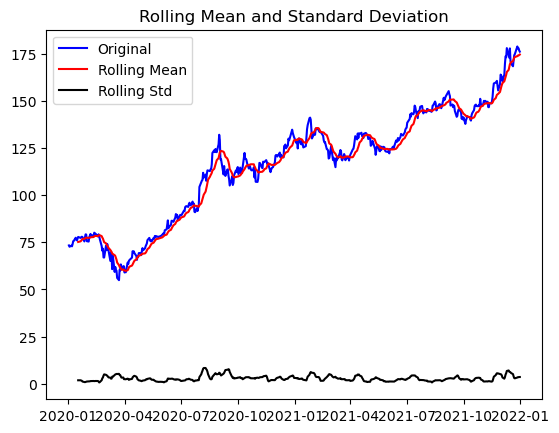

ADF Statistic: -0.232341
p-value: 0.934555


In [14]:
## Rolling mean and std
rolmean = df['close'].rolling(12).mean()
rolstd = df['close'].rolling(12).std()
plt.plot(df, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)
## adfuller test 
adfuller_test(df['close'])

It is obvious that the rolling mean over time of this stock is in an uptrend. p-value generated from Adfuller test is very high. This is non-stationary data.


### Implement Itegrated (d) method to make data stationary

To transfrom this data to stationary form, I use the differencing method with three numbers of d = 1,2,3. 

In [195]:
#### Make data stationary
for d in range(1,4):
    print('*** Adfullter test for d = {}:'.format(d))
    price_diff = df['close'].diff(d).dropna()
    returns = df['close'].pct_change().dropna()
    adfuller_test(price_diff)
    #plt.plot(price_diff, color='blue')
    #plt.title('Differenced price')

*** Adfullter test for d = 1:
ADF Statistic: -25.023766
p-value: 0.000000
*** Adfullter test for d = 2:
ADF Statistic: -4.445814
p-value: 0.000246
*** Adfullter test for d = 3:
ADF Statistic: -4.894004
p-value: 0.000036


p-value in three cases are roughly equals 0, the transformed data in three cases with differencing = 1,2,3 are stationary.

## 2.2. Determine p,q by ACF and PACF

One of most popular methods to choose the value of p,q is using ACF and PACF. They analyze the correlations between the time series and its lagged values to determine the significant lags that should be included in the model: 
* PACF - Partial Auto Correlation Function measures the direct correlation of an observations with its lagged observations. Higher absoluted PACF score means that higher correlation between two observations. Look for the lag in the PACF plot where significant spikes occur. This indicates the number of autoregressive terms to consider for the model (p)
* ACF - Auto Correlation Function measures the correlation between a time series and its lagged values while considering all intermediate lags. The order of MA(q) term is equal to the lags that can cross a significance limit.


In [215]:
def plot_acf_pacf(data, num_lags):
    fig, axes = plt.subplots(1,2,figsize=(12,3))    
    tsap.plot_pacf(data, lags = num_lags, ax = axes[0])
    tsap.plot_acf(data, lags = num_lags, ax = axes[1])
    plt.show()

*** Integrated d = 1


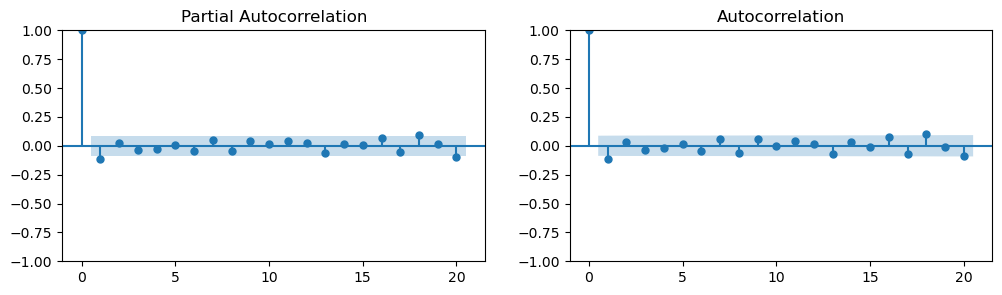

*** Integrated d = 2


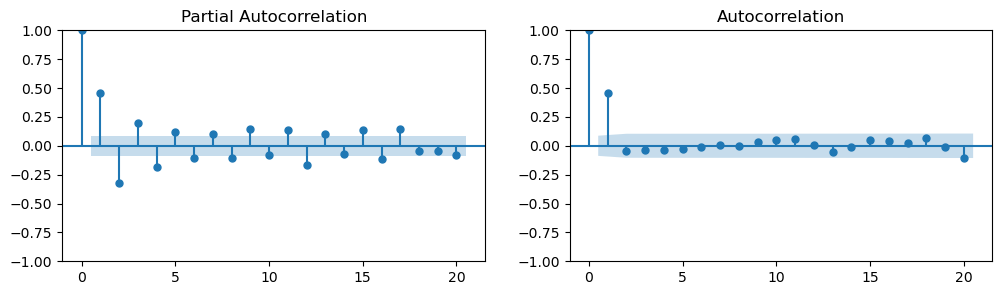

*** Integrated d = 3


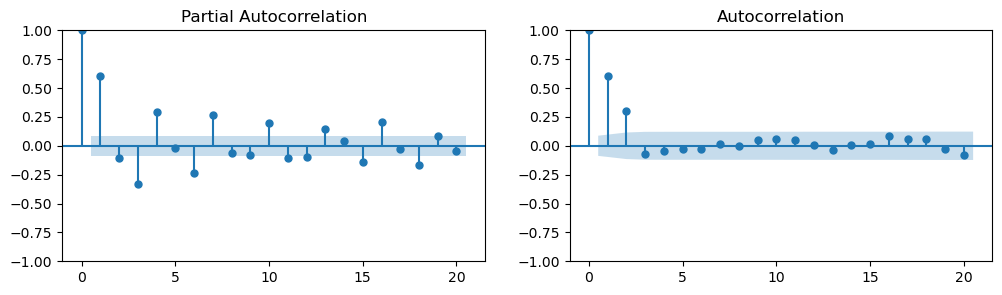

In [264]:
for d in range(1,4):
    print('*** Integrated d = {}'.format(d))
    price_diff = df['close'].diff(d).dropna()
    plot_acf_pacf(price_diff, 20)

* Intergated d = 1

PACF with time lag 1 is slightly across the statistical threshold, while there is no significant signal in PCA graph. It is recommended to choose p = 1, q = 0. 

* Intergated d = 2

In the PACF plot, there are significant spikes at positions 2, 4, 12. In ACF plot, there is a significant drop-off at position 1. Therefore, we can choose p = 2,4,12, and q = 1.

* Intergated d = 3

For d = 3, PACF plot has spikes at positions 3,7,10, ACF has drop off point at position 2. We can choose p = 3,7,10, and q = 2.

Therefore, it is recommended some combinations of (p,d,q): (1,1,0), (2,2,1), (4,2,1), (12,2,1), (3,3,2), (7,3,2), (10,3,2)

## 2.3. Auto ARIMA

Auto ARIMA is available library to choose optimal parameters for ARIMA model by optimizing AIC score. I apply auto ARIMA for three cases of d = 1,2,3

In [249]:
## Split data 
train_data, test_data = df.iloc[:int(N*0.9),:], df.iloc[int(N*0.9):,:]
N_train, N_test = len(train_data), len(test_data)

In [251]:
#### Auto ARIMA
train_data = train_data
for d in range(1,4):
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=10, max_q=10, max_d = 3, # maximum p and q
                          m=0,              # frequency of series
                          d=d,           # let model determine 'd'
                          seasonal=False,   # No Seasonality                      
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    print(model_autoARIMA.summary())
#model_autoARIMA.plot_diagnostics(figsize=(15,8))
#plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2063.963, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2058.942, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2059.389, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2064.140, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2060.483, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2060.206, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2062.203, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2059.709, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.712 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  454
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1026.471
Date:                Sun, 25 Jun 2023   AIC                           2058.942
Time:                        11:39:1

Auto ARIMA function suggests three optimal parameters combination for ARIMA model with d = 1,2,3 are (1,1,0), (10,2,0), (10,3,1).

---

## 3. Implement ARIMA model

I apply ARIMA with 8 different parameters combinations defined by PCF, PACF methods, and Auto ARIMA method:
(1,1,0), (2,2,1), (4,2,1), (12,2,1), (3,3,2), (7,3,2), (10,3,2), (10,2,0), (10,3,0).

ARIMA model will be tested on the 20% of data. During the testing phase, a rolling prediction approach is employed. For each testing point, the model is re-created and trained using all the available previous data. Then, a prediction is made for the next day's price. 

The performance of the model will be evaluated based on two aspects:
* Price Prediction Accuracy: This aspect measures how well the model predicts the next day's price. The accuracy can be quantified using the Root Mean Squared Error (RMSE), which calculates the average difference between the forecasted prices and the actual prices. A lower RMSE indicates a higher accuracy in price prediction.
* Price Direction Accuracy: In addition to predicting the exact price, I am interested in assessing the model's ability to predict the direction of the next day's price. The direction can be defined as whether the price will increase or decrease compared to the current day's price. Based on the predicted price, the direction is  determined. The accuracy rate is dividing the number of correct direction predictions by the total number of test cases.

In [44]:
def plot_predict_result(train_data, test_data, pred_data, title):
# Plot train, test, predicted data
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='Training data')
    plt.plot(test_data, color = 'blue', label='Actual Price')
    plt.plot(pred_data, color = 'orange',label='Predicted Price')    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [170]:
def arima_model(df, test_data, order):
# implement arima model, make rolling prediction
    pred_prices = []
    for pred_date in test_data.index: 
        train_data = df.loc[:pred_date - timedelta(days = 1):,:]        
        model = ARIMA(train_data, order=order, enforce_stationarity=False).fit()
        pred = model.predict(len(train_data)+1).values[0]
        pred_prices.append(pred)    
    pred_prices = pd.Series(pred_prices)
    pred_prices.index = test_data.index
    return(pred_prices)

In [220]:
def price_direction_accuracy(df, pred_prices, N_train, N_test):
    actual_directions = df.iloc[N_train:,:]['close'].pct_change().dropna()
    actual_prev_prices = df.iloc[N_train:,:]['close'].shift(1).dropna()
    pred_directions = (pred_prices - actual_prev_prices)/actual_prev_prices
    direction_accuracy = (actual_directions[1:]*pred_directions[1:]>0).sum()/N_test 
    return(direction_accuracy)

In [255]:
## Split data 
split = 0.8
train_data, test_data = df.iloc[:int(N*split),:], df.iloc[int(N*split):,:]
N_train, N_test = len(train_data), len(test_data)
## ARIMA parameters
orders = [(1,1,0), (2,2,1), (4,2,1), (12,2,1), (3,3,2), (7,3,2), (10,3,2), (10,2,0), (10,3,0)]
rmse_scores, direction_accuracy = [],[]
for order in orders:
    pred_prices = arima_model(df, test_data, order)
    rmse_scores.append(np.sqrt(mean_squared_error(test_data, pred_prices)))
    direction_accuracy.append(price_direction_accuracy(df, pred_prices, N_train, N_test))
result1 = pd.DataFrame([orders, rmse_scores, direction_accuracy]).T

In [265]:
result1.columns = ['Parameters', 'Price Accuracy (RMSE)', 'Price Direction Accuracy']
result1

,Parameters,Price Accuracy (RMSE),Price Direction Accuracy
0,"(1, 1, 0)",2.315875,0.445545
1,"(2, 2, 1)",2.292717,0.554455
2,"(4, 2, 1)",2.295841,0.544554
3,"(12, 2, 1)",2.335699,0.524752
4,"(3, 3, 2)",2.398532,0.554455
5,"(7, 3, 2)",2.885441,0.435644
6,"(10, 3, 2)",2.838426,0.50495
7,"(10, 2, 0)",2.694122,0.50495
8,"(10, 3, 0)",4.007514,0.39604


Among 8 combinations of (p,d,q) that were employed, it appears that using a value of d = 2 yields better accuracy rates for both price prediction and price direction prediction. Increasing the value of p does not contribute to improving the accuracy. 

To select the best model, I further expanded the analysis by generating more models with the parameter d set to 2, while varying the value of p from 0 to 4, and the value of q from 0 to 2.

In [237]:
p_values = range(0,5)
d_values = range(2,3)
q_values = range(0,3)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

rmse_scores, direction_accuracy = [],[]
for order in pdq_combinations:
    pred_prices = arima_model(df, test_data, order)
    rmse_scores.append(np.sqrt(mean_squared_error(test_data, pred_prices)))
    direction_accuracy.append(price_direction_accuracy(df, pred_prices, N_train, N_test))
result2 = pd.DataFrame([pdq_combinations, rmse_scores, direction_accuracy]).T

In [260]:
result2.columns = ['Parameters', 'Price Accuracy (RMSE)', 'Price Direction Accuracy']
result2

,Parameters,Price Accuracy (RMSE),Price Direction Accuracy
0,"(0, 2, 0)",5.05881,0.534653
1,"(0, 2, 1)",2.275615,0.554455
2,"(0, 2, 2)",2.296066,0.584158
3,"(1, 2, 0)",4.020934,0.514851
4,"(1, 2, 1)",2.29469,0.574257
5,"(1, 2, 2)",2.288058,0.554455
6,"(2, 2, 0)",3.647453,0.445545
7,"(2, 2, 1)",2.292717,0.554455
8,"(2, 2, 2)",2.294312,0.544554
9,"(3, 2, 0)",3.409398,0.386139


### Conclusion

In terms of price prediction accuracy, the model with parameters (0, 2, 1) observes the lowest RMSE value of 2.27. However, the difference in accuracy between this model and several other combinations, such as (0,2,2), (1,2,1), (1,2,2), (2,2,1), (3,2,1), (3,2,2), (4,2,1), (4,2,2), was not significant, as they had accuracy rates ranging between 2.8 and 3. 

When it comes to price direction accuracy, the model with parameters (0, 2, 2) achieved the highest accuracy rate of 0.584.

In conclusion, when considering the price prediction accuracy, ARIMA (0,2,1) has lowest RMSE of 2.27. When considering the both aspects of price prediction accuracy and price direction accuracy, ARIMA (0,2,2) performs the best.

### ARIMA(0,2,2)

In [261]:
pred_prices = arima_model(df, test_data, (0,2,2))
rmse = np.sqrt(mean_squared_error(test_data, pred_prices))

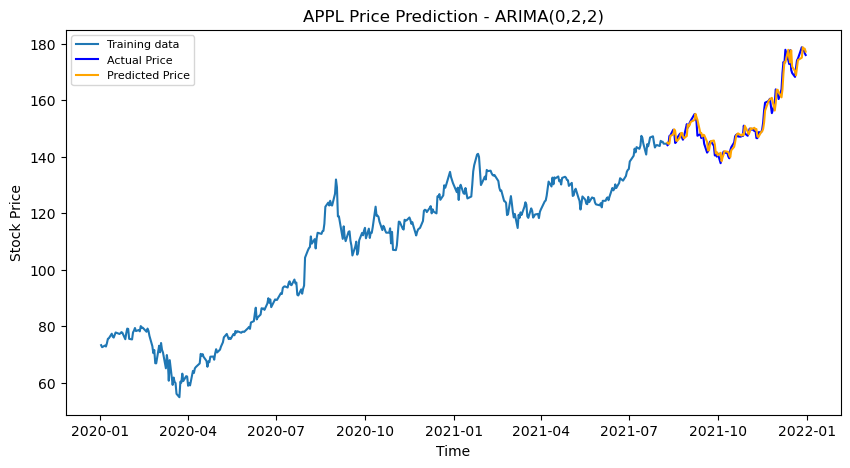

Root Mean Squared Error: 2.296


In [262]:
plot_predict_result(df.iloc[:N_train,:], df.iloc[N_train:,:], pred_prices
                    , 'APPL Price Prediction - ARIMA(0,2,2)')
print(f'Root Mean Squared Error: {rmse:.3f}')

## Reference

https://otexts.com/fpp3/stationarity.html

https://www.youtube.com/watch?v=oY-j2Wof51c

https://pub.towardsai.net/time-series-forecasting-with-arima-models-in-python-part-1-c2940a7dbc48
    